In [1]:
import glob
from datetime import datetime
from functools import reduce
import math as mt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import sqlalchemy as sal

In [2]:
endpoint = "capstone.clihskgj8i7s.us-west-2.rds.amazonaws.com"
user="group3"
db="db1"
#pw=getpass.getpass("Enter database password")
pw=open(r'/Users/aparnagupta/Documents/password.txt',"r").read().rstrip()

In [4]:
engine = sal.create_engine('postgresql://%s:%s@%s/%s' % (user, pw, endpoint, db))

query="""
select timestamp, station, total_flow, avg_speed
from traffic_train
where station = 400717
;
"""
#where station = 400001
#where station = 400717

traffic=pd.read_sql(query, engine)

print(traffic.shape)
traffic.head()

(52111, 4)


,timestamp,station,total_flow,avg_speed
0,2020-01-16 19:10:00,400717,336.0,58.3
1,2020-01-16 19:30:00,400717,305.0,57.8
2,2020-01-16 19:20:00,400717,293.0,57.2
3,2020-01-16 19:25:00,400717,291.0,57.5
4,2020-01-16 19:15:00,400717,313.0,58.6


In [5]:
traffic['timestamp'] = pd.to_datetime(traffic['timestamp'])

In [6]:
traffic['Month'] = pd.DatetimeIndex(traffic['timestamp']).month

In [7]:
traffic['Day'] = pd.DatetimeIndex(traffic['timestamp']).day

In [8]:
traffic['Year'] = pd.DatetimeIndex(traffic['timestamp']).year

In [9]:
import calendar
traffic['Month'] = traffic['Month'].apply(lambda x: calendar.month_abbr[x])

In [10]:
traffic['Time'] = traffic['timestamp'].dt.time

In [11]:
traffic

,timestamp,station,total_flow,avg_speed,Month,Day,Year,Time
0,2020-01-16 19:10:00,400717,336.0,58.3,Jan,16,2020,19:10:00
1,2020-01-16 19:30:00,400717,305.0,57.8,Jan,16,2020,19:30:00
2,2020-01-16 19:20:00,400717,293.0,57.2,Jan,16,2020,19:20:00
3,2020-01-16 19:25:00,400717,291.0,57.5,Jan,16,2020,19:25:00
4,2020-01-16 19:15:00,400717,313.0,58.6,Jan,16,2020,19:15:00
...,...,...,...,...,...,...,...,...
52106,2020-01-16 18:50:00,400717,305.0,61.3,Jan,16,2020,18:50:00
52107,2020-01-16 18:55:00,400717,332.0,60.0,Jan,16,2020,18:55:00
52108,2020-01-16 19:00:00,400717,340.0,59.9,Jan,16,2020,19:00:00
52109,2020-01-16 18:45:00,400717,308.0,59.8,Jan,16,2020,18:45:00


In [12]:
AvgVehicleCount = traffic[['Month','Day','Time','station','total_flow']]

In [13]:
AvgVehicleCount = AvgVehicleCount[(AvgVehicleCount["Month"] =='Apr')].reset_index(drop=True)

In [14]:
AvgVehicleCount

,Month,Day,Time,station,total_flow
0,Apr,1,00:00:00,400717,68.0
1,Apr,1,00:05:00,400717,81.0
2,Apr,1,00:10:00,400717,68.0
3,Apr,1,00:15:00,400717,70.0
4,Apr,1,00:20:00,400717,72.0
...,...,...,...,...,...
8634,Apr,30,23:35:00,400717,71.0
8635,Apr,30,23:40:00,400717,107.0
8636,Apr,30,23:45:00,400717,83.0
8637,Apr,30,23:50:00,400717,72.0


In [15]:
AvgVehicleSpeed = traffic[['Month','Time','station','avg_speed']]

In [16]:
AvgVehicleSpeed = AvgVehicleSpeed[(AvgVehicleSpeed["Month"] =='Apr')].reset_index(drop=True)

In [17]:
AvgVehicleSpeed

,Month,Time,station,avg_speed
0,Apr,00:00:00,400717,63.4
1,Apr,00:05:00,400717,63.7
2,Apr,00:10:00,400717,63.0
3,Apr,00:15:00,400717,63.6
4,Apr,00:20:00,400717,63.5
...,...,...,...,...
8634,Apr,23:35:00,400717,63.4
8635,Apr,23:40:00,400717,63.7
8636,Apr,23:45:00,400717,63.2
8637,Apr,23:50:00,400717,63.5


In [18]:
AvgVehicleCount.total_flow.fillna(value=0, inplace=True)

In [19]:
AvgVehicleSpeed.avg_speed.fillna(value=0, inplace=True)

In [20]:
AvgVehicleCount.to_csv('AvgVehicleCount.csv', index = False)

In [21]:
AvgVehicleSpeed.to_csv('AvgVehicleSpeed.csv', index = False)

In [22]:
AvgVehicleCount = pd.read_csv('AvgVehicleCount.csv', header=0)

In [34]:
class AutoRegressive(nn.Module):
    def __init__(self, df, lag=1, noObservations=1, batchsize=100, bias=True ):
        # Input the AR parameters
        # Building only for linear data for now
        super(AutoRegressive, self).__init__()
        assert type(lag) == int
        assert lag >= 0
        # Initialize Auto Regressive parameter
        self.lag = lag        
        self.df = df
        self.bias = bias
        self.noObservations = noObservations
        self.batchsize = batchsize
        
        self.linear = nn.Linear(self.lag, 1, bias=True).double()
        
        x, y = self.create_dataset(self.df, self.lag)
        
        self.x = x
        self.y = y
                       
    def get_list(self,x, m):
        return list(zip(*(x[i:] for i in range(m))))

    def create_dataset(self,input_df,lag):
        dft = input_df
        print(dft.shape)
        w = lag
        x = []
        print(dft.shape[0])
        x = (self.get_list(dft, w+1))

        x = np.array(x)
        print(type(x))
        y = torch.tensor(x[:, -1])
        x = torch.tensor(x[:, :-1])
        return x, y
    
    def fit(self):
        x = self.x
        y = self.y
        yfit = torch.empty((self.y.shape[0]))
        train_loader = DataLoader(TensorDataset(x, y), batch_size=self.batchsize, shuffle=True)
        optimizer = torch.optim.RMSprop(self.parameters(), lr=0.001)
        criterion = torch.nn.MSELoss(reduction='mean')
        for e in range(10):
            loss_total = 0
            for xi, yi in tqdm(train_loader):
                xi, yi = xi.to('cpu'), yi.to('cpu')
                optimizer.zero_grad()
                assert xi.shape[1] == self.lag           
                yfit = self(xi.double()).flatten()
                loss = criterion(yi.double(),yfit)
                loss.backward(retain_graph=True)
                optimizer.step()
                loss_total += loss
            loss = (loss_total / len(y))
        print(e, loss)
        yfitval = torch.empty((self.y.shape[0]))
        #print(y)
        for i in range(0,len(self.x)):
            #print(i)
            yfitval[i] = self(self.x[i].double()).flatten()
        return loss,yfitval, y
    
    def predict(self):
        x = self.x
        y = self.y 
        df = self.df
        ypredict = torch.empty((self.noObservations)+1)
        xarray = torch.tensor(x[-1:]) # last scalar array of #Lag items
        y3 = torch.empty((self.noObservations)+1,self.lag)
        #print(xarray.shape[1])
        for i in range(xarray.shape[1]):
            #print(xarray[0][i])
            y3[0][i] = xarray[0][i]
        for j in range(0,(self.noObservations)):
            ypredict[j] = self(xarray.double()).flatten()  
            #print(type(ypredict))
            for i in (range(xarray.shape[1])):
                if i<(self.lag-1):
                    #print(j,i)
                    xarray[0][i]=y3[j][i+1]
                if i==(self.lag-1):
                    #print(j,i)
                    xarray[0][i]=ypredict[j] 
            for i in (range(xarray.shape[1])):
                y3[j+1][i] = xarray[0][i]
                #print(y3[j+1][i])
        return ypredict
    
        
    def forward(self, x):
        return self.linear(x)
        


In [35]:
net2 = AutoRegressive(df=AvgVehicleSpeed["avg_speed"],lag=3,noObservations=60,batchsize=1)

(8639,)
8639
<class 'numpy.ndarray'>


In [36]:
x = torch.empty((AvgVehicleSpeed.shape[0]), 5)

In [37]:
yfit = torch.empty((AvgVehicleSpeed.shape[0]))

In [38]:
yact = torch.empty((AvgVehicleSpeed.shape[0]))

In [39]:
z,yfit,yact = net2.fit()

100%|██████████| 8636/8636 [00:03<00:00, 2576.64it/s]


9 tensor(0.9666, dtype=torch.float64, grad_fn=<DivBackward0>)


In [40]:
print(yact)

tensor([63.6000, 63.5000, 63.3000,  ..., 63.2000, 63.5000, 63.7000],
       dtype=torch.float64)


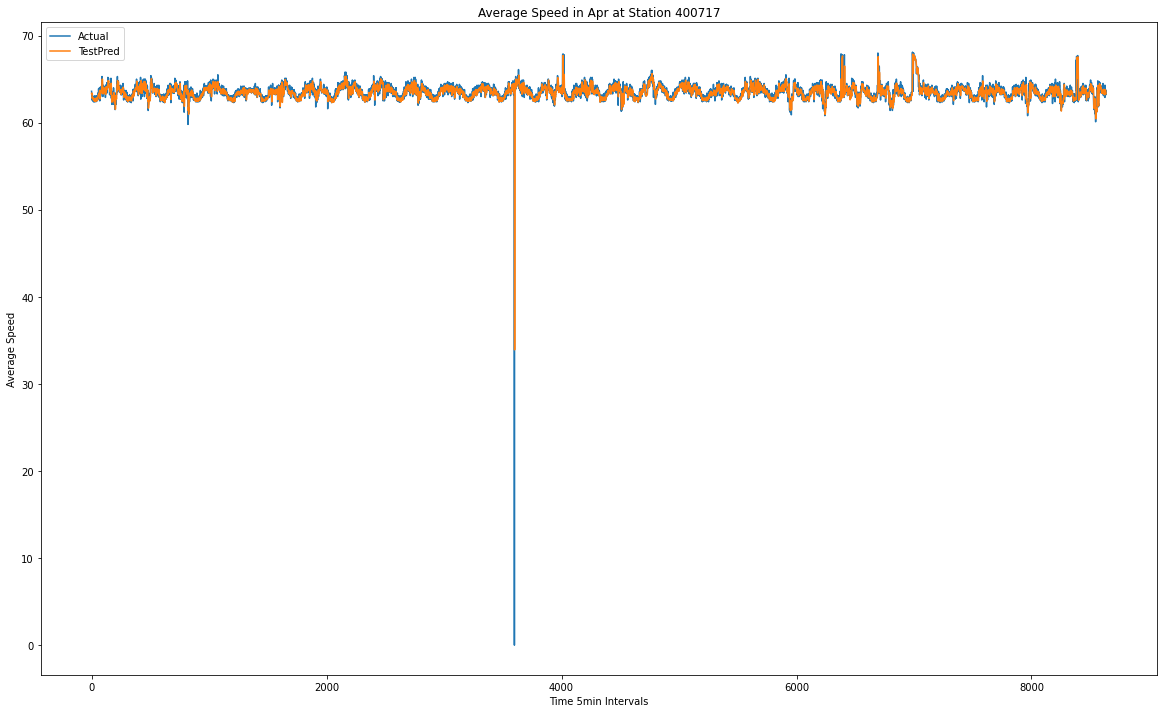

In [41]:
plt.figure(figsize=(20, 12))
plt.plot(yact.detach().numpy())
plt.plot(yfit.detach().numpy())
#plt.xticks(testpred,AvgVehicleCount_ts["Month"])
plt.xlabel('Time 5min Intervals')
plt.ylabel('Average Speed')
plt.legend(['Actual', 'TestPred'])
plt.title(f'Average Speed in Apr at Station 400717')
plt.savefig('Station 400717 test traffic_Average Speed Prediction', bbox_inches='tight')

In [42]:
ypred = net2.predict()

/Users/aparnagupta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


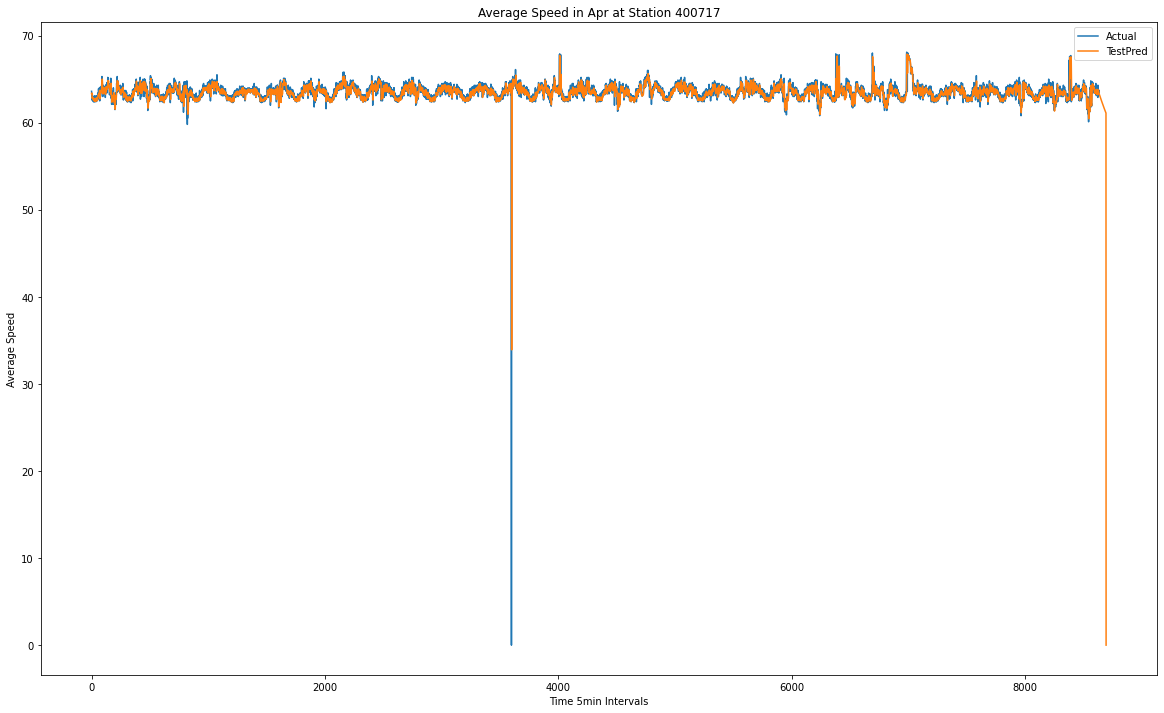

In [43]:
predicted = torch.cat((yfit,ypred),0)
plt.figure(figsize=(20, 12))
plt.plot(yact.detach().numpy())
plt.plot(predicted.detach().numpy())
#plt.xticks(testpred,AvgVehicleCount_ts["Month"])
plt.xlabel('Time 5min Intervals')
plt.ylabel('Average Speed')
plt.legend(['Actual', 'TestPred'])
plt.title(f'Average Speed in Apr at Station 400717')
plt.savefig('Station 400717 test traffic_Average Speed Prediction', bbox_inches='tight')